# Taxa abundance plots relative VS quantitative

In [2]:
setwd('/Users/vera/Desktop/lab_counts/16S_analysis')
library('phyloseq')
library('ggplot2')
library('plyr')
library('vegan')
library('data.table')
library('cowplot')

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Part1: relative abundance

## build phyloseq OTU object

In [2]:
otumat_16s <- read.csv('otu_table.csv', header = TRUE)
rownames(otumat_16s) <- otumat_16s[,1]
otumat_16s <- otumat_16s[,2:55]
OTU_16s <- otu_table(otumat_16s, taxa_are_rows=TRUE)
#head(otumat_16s)

## build phyloseq counts object

In [3]:
counts <- read.csv('counts_roundup.csv', header = TRUE)
counts <- as.matrix(counts)
counts_16s <- matrix(data = NA, nrow = 54, ncol = 8)
rownames(counts_16s) <- colnames(otumat_16s)
colnames(counts_16s) <- colnames(counts)[2:9]
for (i in 1:54) {
  num <- match(colnames(otumat_16s)[i], counts[,1])
  counts_16s[i,] <- as.vector(counts[num,2:9])
}
counts_16s <- as.data.frame(counts_16s)
counts_16s <- counts_16s[order(counts_16s$bacteria_counts, decreasing=TRUE),]
sampledata_counts_16s <- sample_data(counts_16s)

## build phyloseq taxa object

In [4]:
taxmat_16s <- read.table('Sloan_16S_OTU_IDs_copy.txt', header = TRUE, sep = '\t', na.strings = "")
rownames(taxmat_16s) <- taxmat_16s[,1]
taxmat_16s <- taxmat_16s[,2:8]
TAX_16s = tax_table(as.matrix(taxmat_16s))
#head(taxmat_16s)

## combine all object into one phyloseq object

In [5]:
physeq_16s <- phyloseq(OTU_16s, TAX_16s, sampledata_counts_16s)
#random_tree_16s = rtree(ntaxa(physeq_16s), rooted=TRUE, tip.label=taxa_names(physeq_16s))
#physeq_16s = merge_phyloseq(physeq_16s, random_tree_16s)

## merge species that have the same Order/Genus and convert phyloseq object into data frame

In [6]:
glom <- tax_glom(physeq_16s, taxrank = 'order')
data_glom <- data.table(psmelt(glom))
data_glom$order <- as.character(data_glom$order)

## only show top 15 OTUs, the rest are grouped into "Other"

In [7]:
medians <- ddply(data_glom, ~order, function(x) c(median=median(x$Abundance)))
medians <- medians[order(medians$median, decreasing=TRUE),]
other <- medians$order[16:length(medians$order)]
data_glom[data_glom$order %in% other,]$order <- 'Other'
#top15_OTUs_unscaled <- medians$order[1:15] #top 15 OTUs in relative abundance
#Count = length(unique(data_glom$genus))

## rank OTUs from high abundances to low abundances

### for Order level

In [8]:
data_glom$order <- factor(data_glom$order, levels = c('Streptophyta', 'Actinomycetales', 'Bacillales', 'Burkholderiales', 'Rickettsiales', 'Pseudomonadales', 'Enterobacteriales', 'Rhizobiales', 'Clostridiales', 'Desulfuromonadales', 'Erysipelotrichales', 'Sphingomonadales', 'Lactobacillales', 'Flavobacteriales', 'Bacteroidales', 'Other'))

### for Genus level

In [9]:
#data_glom$genus <- factor(data_glom$genus, levels = c('Erwinia', 'Pseudomonas', 'Geobacter', 'PSB-M-3', 'Bacillus', 'Corynebacterium', 'Micrococcus', 'Acinetobacter', '29-Apr', 'A17', 'Acetobacter', 'Acetobacterium', 'Acholeplasma', 'Achromobacter', 'Acidaminobacter', 'Other'))

## plot relative abundance

In [12]:
colors <- c('#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#800000', '#808000', '#000075', '#a9a9a9')
plot <- ggplot(data=data_glom, aes(x=Sample, y=Abundance)) + 
geom_bar(aes(fill=order), stat="identity", position="fill") +
scale_fill_manual(values=colors) +
theme(legend.text=element_text(size=6), legend.key.size=unit(0.5,'cm'), axis.text.x = element_text(angle = 90, hjust = 0.5), legend.position="right") + guides(fill=guide_legend(direction='vertical',ncol=1))+
labs(y = "Relative Abundance")

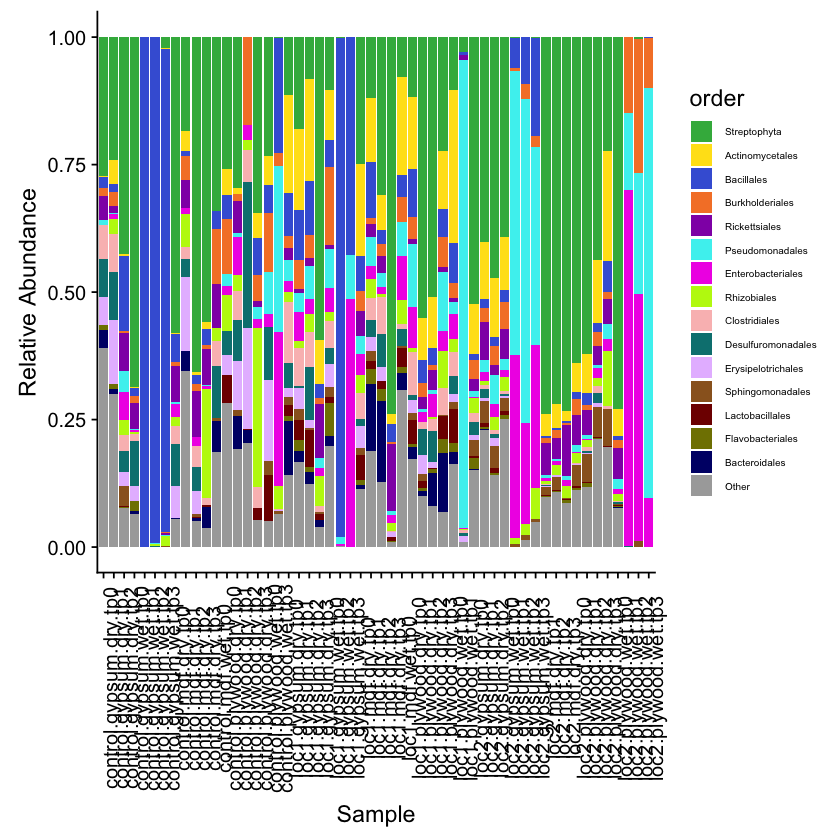

In [13]:
plot

# Part2: quantitative abundance

## build a new phyloseq OTU object for absolute count data

In [31]:
otu_abs <- read.csv('otu_table_abs.csv', header = TRUE)
rownames(otu_abs) <- otu_abs[,1]
otu_abs <- otu_abs[,2:55]
OTU_abs <- otu_table(otu_abs, taxa_are_rows=TRUE)

## combine all objects into a new phyloseq object

In [32]:
physeq_abs <- phyloseq(OTU_abs, TAX_16s, sampledata_counts_16s)

## merge species that have the same Order/Genus and convert phyloseq object into data frame

In [34]:
glom_abs <- tax_glom(physeq_abs, taxrank = 'order')
data_glom_abs <- data.table(psmelt(glom_abs))
data_glom_abs$order <- as.character(data_glom_abs$order)

## only show top 15 OTUs, the rest are grouped into "Other"

In [35]:
medians_abs <- ddply(data_glom_abs, ~order, function(x) c(median=median(x$Abundance)))
medians_abs <- medians_abs[order(medians_abs$median, decreasing=TRUE),]
other_abs <- medians_abs$order[16:length(medians_abs$order)]
data_glom_abs[data_glom_abs$order %in% other_abs,]$order <- 'Other'
#top15_OTUs_scaled <- medians_abs$order[1:15] #top 15 OTUs in absolute abundance
#Count_abs = length(unique(data_glom_abs$order))

## rank OTUs from high abundance to low abundance

### for Order level

In [36]:
data_glom_abs$order <- factor(data_glom_abs$order, levels = c('Streptophyta', 'Bacillales', 'Actinomycetales', 'Enterobacteriales', 'Burkholderiales', 'Pseudomonadales', 'Rickettsiales', 'Rhizobiales', 'Clostridiales', 'Sphingomonadales', 'Desulfuromonadales', 'Erysipelotrichales',  'Lactobacillales', 'Rhodospirillales', 'Flavobacteriales', 'Other'))

## plot quantitative abundance

In [42]:
colors_abs <- c('#3cb44b', '#4363d8', '#ffe119',  '#f032e6', '#f58231', '#46f0f0', '#911eb4', '#bcf60c', '#fabebe', '#9a6324', '#008080', '#e6beff', '#800000', '#469990', '#808000', '#a9a9a9')
plot_abs <- ggplot(data=data_glom_abs, aes(x=Sample, y=Abundance)) + 
geom_bar(aes(fill=order), stat="identity", position="stack") +
scale_fill_manual(values=colors_abs) +
theme(legend.text=element_text(size=6), legend.key.size=unit(0.5,'cm'), axis.text.x = element_text(angle = 90, hjust = 0.5), legend.position="right") + guides(fill=guide_legend(direction='vertical',ncol=1)) +
labs(y = "Quantitative Abundance")

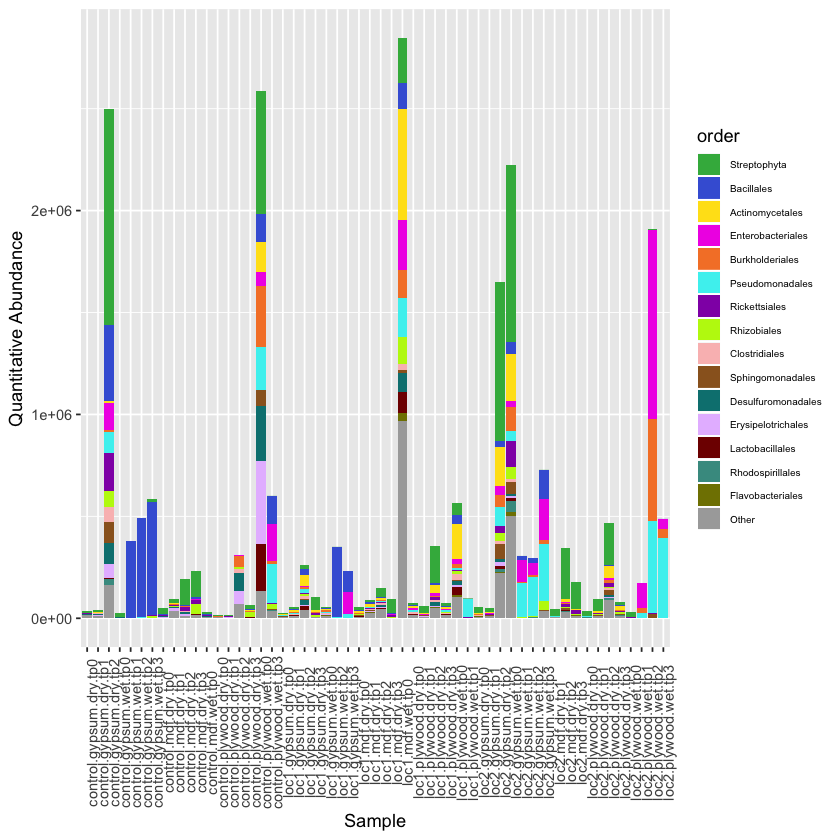

In [43]:
plot_abs

# PCoA plots

## Part1: relative data

### remove taxa not seen more than 3 times in at least 20% of the samples

In [47]:
filtered_rel = filter_taxa(physeq_16s, function(x) sum(x > 3) > (0.2*length(x)), TRUE)

Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”

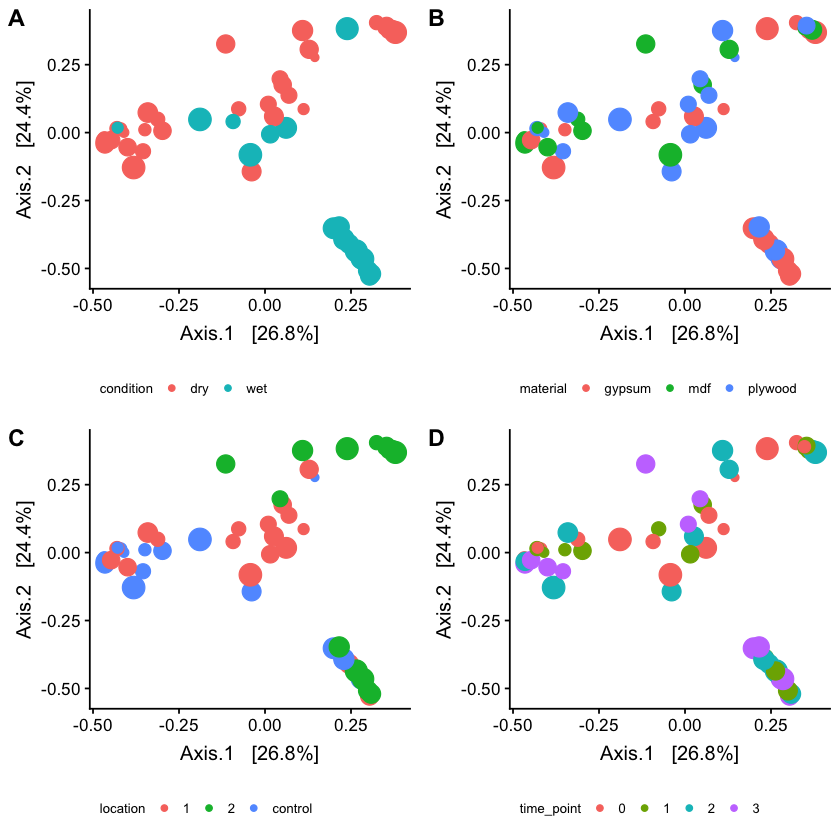

In [83]:
theme_set(theme_cowplot(font_size=12))
ord_rel = ordinate(filtered_rel, "PCoA", "bray")

bc1 <- plot_ordination(filtered_rel, ord_rel, color = 'condition') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8)) 
bc2 <- plot_ordination(filtered_rel, ord_rel, color = 'material') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
bc3 <- plot_ordination(filtered_rel, ord_rel, color = 'location') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
bc4 <- plot_ordination(filtered_rel, ord_rel, color = 'time_point') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))

plot_grid(bc1, bc2, bc3, bc4, labels='AUTO')

Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”

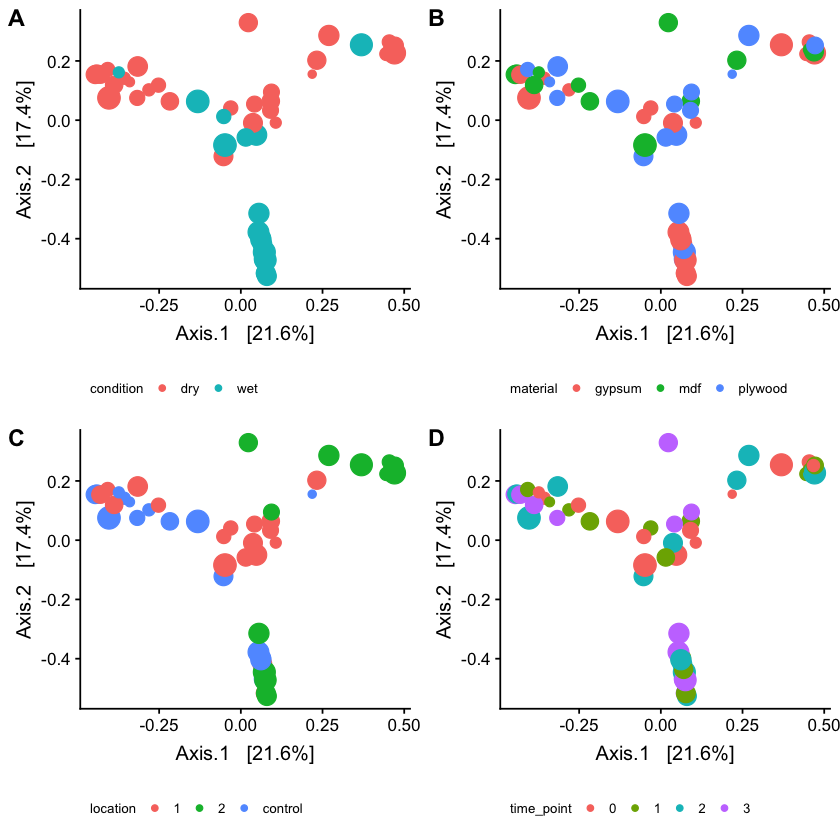

In [84]:
ord_rel_ja = ordinate(filtered_rel, "PCoA", "jaccard")

ja1 <- plot_ordination(filtered_rel, ord_rel_ja, color = 'condition') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8)) 
ja2 <- plot_ordination(filtered_rel, ord_rel_ja, color = 'material') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
ja3 <- plot_ordination(filtered_rel, ord_rel_ja, color = 'location') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
ja4 <- plot_ordination(filtered_rel, ord_rel_ja, color = 'time_point') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))

plot_grid(ja1, ja2, ja3, ja4, labels='AUTO')

#### Weighted UniFrac

In [4]:
biom_data <- import_biom(BIOMfilename = "qiime2/Phyloseq/table-with-taxonomy.biom", 
                         treefilename = "qiime2/Phyloseq/tree.nwk")
mapping_file <- import_qiime_sample_data(mapfilename = "qiime2/metadata.txt")
physeq_unifrac <- merge_phyloseq(biom_data, mapping_file)

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [5]:
physeq_unifrac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2559 taxa and 54 samples ]
sample_data() Sample Data:       [ 54 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 2559 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2559 tips and 2548 internal nodes ]

In [ ]:
filtered_rel_unifrac = filter_taxa(physeq_unifrac, function(x) sum(x > 3) > (0.2*length(x)), TRUE)

## Part2: quatitative data

In [57]:
filtered_qua = filter_taxa(physeq_abs, function(x) sum(x > 3) > (0.2*length(x)), TRUE)

Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”

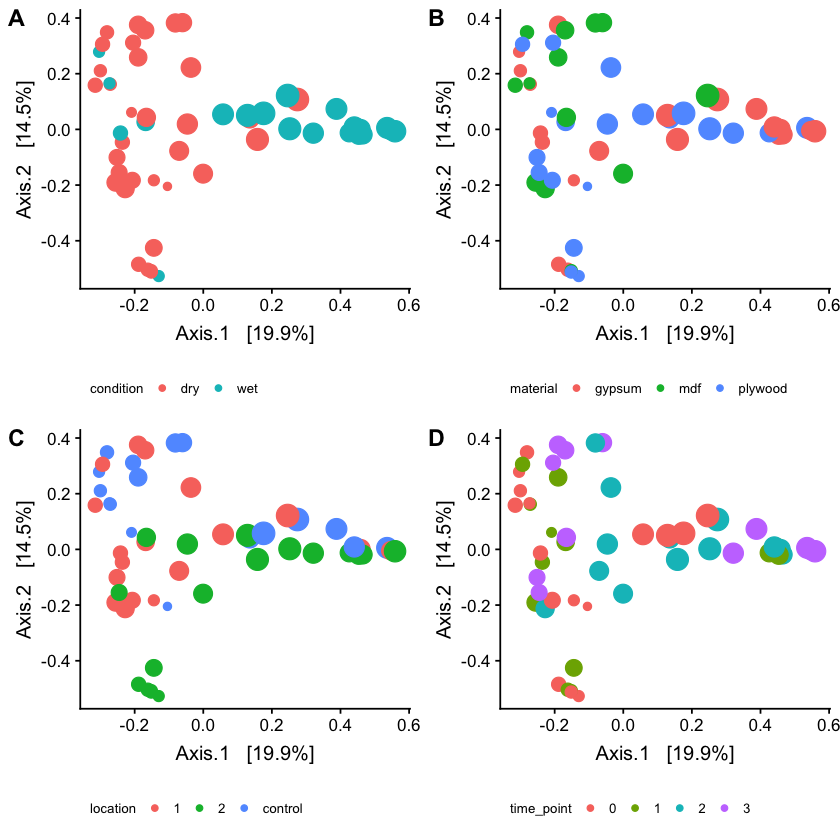

In [85]:
theme_set(theme_cowplot(font_size=12))
ord_qua_bc = ordinate(filtered_qua, "PCoA", "bray")

bc5 <- plot_ordination(filtered_qua, ord_qua_bc, color = 'condition') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8)) 
bc6 <- plot_ordination(filtered_qua, ord_qua_bc, color = 'material') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
bc7 <- plot_ordination(filtered_qua, ord_qua_bc, color = 'location') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
bc8 <- plot_ordination(filtered_qua, ord_qua_bc, color = 'time_point') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))

plot_grid(bc5, bc6, bc7, bc8, labels='AUTO')

Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”Warning message:
“Using size for a discrete variable is not advised.”

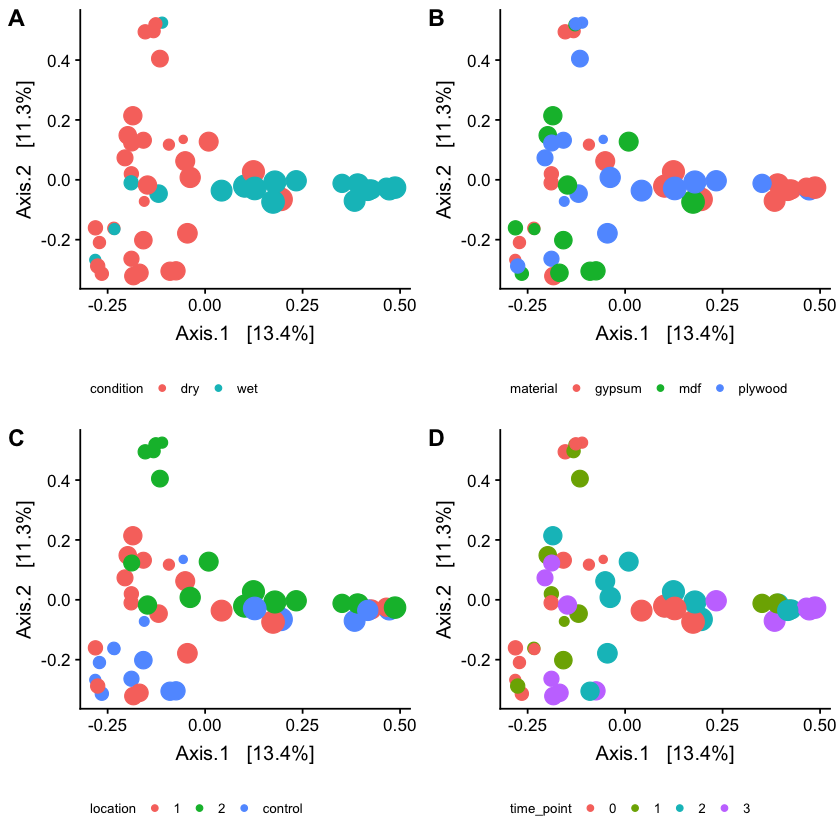

In [86]:
ord_qua_ja = ordinate(filtered_qua, "PCoA", "jaccard")

ja5 <- plot_ordination(filtered_qua, ord_qua_ja, color = 'condition') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8)) 
ja6 <- plot_ordination(filtered_qua, ord_qua_ja, color = 'material') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
ja7 <- plot_ordination(filtered_qua, ord_qua_ja, color = 'location') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))
ja8 <- plot_ordination(filtered_qua, ord_qua_ja, color = 'time_point') +
       geom_point(aes(size = bacteria_counts_roundup), show.legend=FALSE) + 
       theme(legend.text=element_text(size=8), legend.position="bottom", legend.title = element_text(size=8))

plot_grid(ja5, ja6, ja7, ja8, labels='AUTO')